In [3]:
import sklearn

import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path
IMAGES_PATH = Path() / "images" / "training_linear_models"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH = Path() / "output"
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
import os

current_path = os.getcwd()
print("当前工作路径:", current_path)

当前工作路径: d:\大三下\python\HW4


In [5]:
import numpy as np
import pandas as pd
import re
import cn2an

frame_patterns = {
    'room': r'(\d+)室',     
    'hall': r'(\d+)厅',      
    'kitchen': r'(\d+)厨',   
    'bathroom': r'(\d+)卫',
    'apartment': r'(\d+)房间' 
}

def get_lift_ratio(s):
    if pd.isna(s):
        return None
    match = re.search(r'([^梯]+)梯([^户]+)户', s)
    if match:
        try:
            lift_num = cn2an.cn2an(match.group(1), 'normal')
            household_num = cn2an.cn2an(match.group(2), 'normal')
            return lift_num / household_num
        except Exception as e:
            print(f"转换错误：{e}")
            return None
    else:
        return None
    
def get_relative_height(s):
    if pd.isna(s):
        return None
    match = re.search(r'([^()]+)', s)
    if match:
        return match.group(1).strip() 
    else:
        return None

def get_total_floor(s):
    if pd.isna(s):
        return None
    match = re.search(r'\s*\((共(\d+)层)\)', s)
    if match:
        return int(match.group(2))
    else:
        return None
    
direction_mapping = {
    '东': 'east',
    '西': 'west',
    '南': 'south',
    '北': 'north',
    '东南': 'south_east',
    '东北': 'north_east',
    '西南': 'south_west',
    '西北': 'north_west'
}

def process_directions(direction_str):
    directions = direction_str.split()
    processed_directions = []
    for direction in directions:
        if direction in direction_mapping:
            processed_directions.append(direction_mapping[direction])
    return processed_directions


    

In [7]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

def preprocess(df):
    # 重命名列
    df.rename(columns={
        '城市': 'location1', 
        '区域': 'location2',
        '板块': 'location3',
        '环线': 'ring',
        '小区名称': 'location4',
        '价格': 'price',
        '建筑面积': 'area_gross',
        '套内面积': 'area_net',
        '房屋朝向': 'directions',
        '建筑结构': 'structure',
        '房屋户型': 'frame',
        '所在楼层': 'floor',
        '梯户比例': 'lift_ratio',
        '装修情况': 'decoration',
        '配备电梯': 'lift_ornot',
        '别墅类型': 'villa',
        '交易权属': 'transaction_ownership',
        '房屋用途': 'purpose',
        '房屋年限': 'age',
        '产权所属': 'property_ownership',
        '年份': 'year'
    }, inplace=True)
    
    df['area_gross'] = df['area_gross'].str.replace('㎡', '').astype(float)
    df['area_net'] = df['area_net'].str.replace('㎡', '').astype(float)
    
    for i in range(1, 4):
        df['location' + str(i)] = df['location' + str(i)].astype(int).astype(str)
    
    for key, pattern in frame_patterns.items():
        df[key] = df['frame'].str.extract(pattern, expand=False).fillna(0).astype(int)

    dummies=pd.get_dummies(df['location1'],columns=['location1'],prefix='location1',drop_first=False)
    df=pd.concat([df,dummies],axis=1)

    dummies=pd.get_dummies(df['ring'],columns=['ring'],prefix='ring',drop_first=False)
    df=pd.concat([df,dummies],axis=1)


    df['lift_ratio'] = df['lift_ratio'].apply(get_lift_ratio)
    df['lift_ratio'] = df['lift_ratio'].fillna(df[~df['lift_ratio'].isna()]['lift_ratio'].mean())
    df['relative_height']=df['floor'].apply(get_relative_height)
    df['total_floor']=df['floor'].apply(get_total_floor)

    df['directions'] = df['directions'].apply(process_directions)
    dummies = df['directions'].apply(lambda x: pd.Series([1 if d in x else 0 for d in direction_mapping.values()]))
    dummies.columns = direction_mapping.values()
    df = pd.concat([df, dummies], axis=1)
    
    df['structure']=df['structure'].fillna('建筑结构未知')
    df['decoration']=df['decoration'].fillna('装修情况未知')
    df['lift_ornot']=df['lift_ornot'].fillna('配备电梯未知')
    df['villa']=df['villa'].fillna('非别墅')
    df['property_ownership']=df['property_ownership'].fillna('产权所属未知')
    df['purpose']=df['purpose'].fillna('房屋用途未知')
    df['age']=df['age'].fillna('房屋年限未知')
    df['year']=df['year'].astype(int).astype(str)


    df = df.drop(['frame','floor','directions'], axis=1)
    
    return df

train_df = preprocess(train_df)
test_df = preprocess(test_df)

temp_df = train_df[['area_gross', 'area_net']][~train_df['area_net'].isnull()]
temp_df['net_ratio'] = temp_df['area_net'] / temp_df['area_gross']
net_ratio_mean = temp_df['net_ratio'].mean()
del temp_df

print('net_ratio_mean=', net_ratio_mean)

train_df.loc[train_df['area_net'].isnull(), 'area_net'] = net_ratio_mean * train_df.loc[train_df['area_net'].isnull(), 'area_gross']
test_df.loc[test_df['area_net'].isnull(), 'area_net'] = net_ratio_mean * test_df.loc[test_df['area_net'].isnull(), 'area_gross']

del net_ratio_mean

net_ratio_mean= 0.8081159923632094


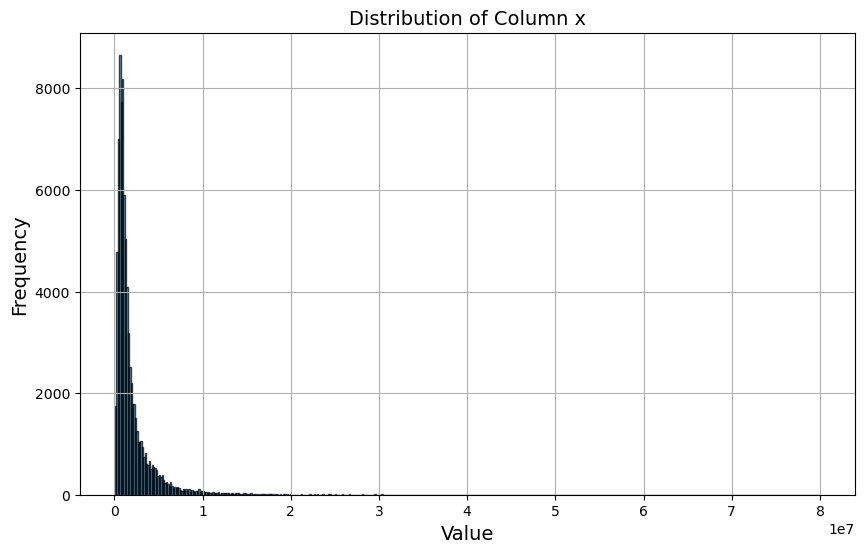

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(train_df['price'], bins=500, edgecolor='black', alpha=0.7)
plt.title('Distribution of Column x')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [147]:
print(train_df.head())
train_df.to_csv('train_df.csv',encoding='utf-8-sig',index=False)

  location1 location2 location3  ring location4     price  area_gross  \
0         0        79       111  二至三环     人定湖西里   6564200       52.30   
1         0        43       231  五至六环     龙跃苑四区   4174000      127.44   
2         0        97        54  五至六环       名都园  16310000      228.54   
3         0        62       568  三至四环    保利海德公园   2834600       43.60   
4         0        62       226  三至四环   京投银泰琨御府   1954000       39.85   

     area_net structure decoration  ...  relative_height total_floor east  \
0   42.264466      混合结构         精装  ...              中楼层           5    0   
1  123.700000      混合结构         精装  ...               顶层           6    0   
2  184.686829      混合结构         精装  ...               底层           3    0   
3   29.390000      钢混结构         精装  ...              低楼层          10    0   
4   29.940000      钢混结构         精装  ...              中楼层          10    0   

  west south north south_east north_east south_west  north_west  
0    0     1     1          0   

In [148]:
def get_location_relation_df(location_index,train,test_df):
    if location_index==1:raise ValueError("城市数据齐全，不需要进行同级估计。")
    if location_index>4:raise ValueError("请选择正确的地理区分度！")
    location_upper='location'+str(location_index-1)
    location_lower='location'+str(location_index)
    locations_df=pd.concat([train_df[[location_upper,location_lower]],test_df[[location_upper,location_lower]]],axis=0,ignore_index=True)
    location_lower_unique_list=np.sort(locations_df[location_lower].unique())
    train_location_lower_unique_list=np.sort(train_df[location_lower].unique())
    len_list=len(location_lower_unique_list)
    location_upper_list=np.empty(len_list,dtype=str)
    location_lower_list=location_lower_unique_list
    location_lower_isin_train=np.empty(len_list,dtype=bool)
    
    for i in range(len(locations_df)):
        this_location_lower=locations_df[location_lower][i]
        if  this_location_lower in location_lower_unique_list:
            index=np.where(location_lower_list==this_location_lower)[0][0]
            location_upper_list[index]=locations_df[location_upper][i]
            location_lower_isin_train[index]=np.isin(train_location_lower_unique_list,this_location_lower).any()
            location_lower_unique_list=location_lower_unique_list[location_lower_unique_list != this_location_lower]
        if len(location_lower_unique_list)==0:break
    
    location_relation_df=pd.DataFrame({
        location_upper:location_upper_list,
        location_lower:location_lower_list,
        location_lower+'_isin_train':location_lower_isin_train
    })
    return(location_relation_df)




In [149]:
area_class='area_gross'
location_index=4
location_relation_df=get_location_relation_df(location_index,train_df,test_df)
neighbor_num=10
is_upper=True

def get_neighbor_location_list(this_location,location_index=None,location_relation_df=None,train_df=None,neighbor_num=None):
    if is_upper:
        location_upper='location'+str(location_index-1)
        location_lower='location'+str(location_index)
        if location_index is None:raise ValueError("当采用上级法估计邻居时，必须提供主人的区域级别！")
        if location_index == 1:raise ValueError("当取城市级地理区分度无须估计邻居！")
        if location_index > 4 :raise ValueError("请选择正确的地理区分度！") 
        if not ('location'+str(location_index)+'_isin_train' in location_relation_df.columns):
            raise ValueError("地理区分度与地理从属关系不匹配！")
        temp_series=location_relation_df[location_relation_df[location_lower]==this_location][location_upper]
        if temp_series.empty:
            return([])
        else:
            this_location_upper=temp_series.iloc[0]
            neighbor_location_list=list(location_relation_df[(location_relation_df[location_upper] == this_location_upper)&(location_relation_df['location'+str(location_index)+'_isin_train'])][location_lower])
        return(neighbor_location_list)
    else:
        if neighbor_num is None or train_df is None:raise ValueError("若采用距离邻近法估计邻居，则必须提供邻居数与训练集！")
        train_location_list=np.sort(np.unique(train_df['location'+str(location_index)]).astype(int))
        sorted_indices=np.argsort(np.abs(train_location_list-this_location))
        neighbor_location_list=train_location_list[sorted_indices[range(neighbor_num)]]
        return(neighbor_location_list.astype(str))
                



In [150]:
print([col for col in train_df.columns if 'ring_' in col])
print([col for col in train_df.columns if 'location1_' in col])

['ring_一环内', 'ring_一至二环', 'ring_三环外', 'ring_三至四环', 'ring_中环至外环', 'ring_二环内', 'ring_二至三环', 'ring_五至六环', 'ring_六环外', 'ring_内环内', 'ring_内环至中环', 'ring_内环至外环', 'ring_四环外', 'ring_四至五环', 'ring_外环外']
['location1_0', 'location1_1', 'location1_2', 'location1_3', 'location1_4', 'location1_5', 'location1_6']


In [151]:
from patsy import dmatrix
import itertools

linear_variable_name_list = ['room', 'hall', 'kitchen', 'bathroom', 'apartment']
nonlinear_variable_name_list = ['area_gross','area_net', 'lift_ratio']  
interaction_variable_name_list = ['C(location1):C(ring)']
dummy_variable_name_list = ['location1','location'+str(location_index),'ring','structure', 'decoration', 'lift_ornot', 'villa', 'transaction_ownership', 'purpose', 'age', 'property_ownership', 'year', 'relative_height', 'east', 'west', 'south', 'north', 'south_east', 'north_east', 'south_west', 'north_west']


def get_basic_feature_matrix(df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list):
    nonlinear_formula = ' + '.join([f'{name} + np.power({name}, 2) + np.power({name}, 3) + np.log({name}) + np.log({name})**2 + np.log({name})**3' for name in nonlinear_variable_name_list])
    linear_formula = '+'.join([f'{name}' for name in linear_variable_name_list])
    interaction_formula = ' + '.join([f'{name1}:{name2}' for name1, name2 in itertools.combinations(interaction_variable_name_list, 2)])
    parts = []
    if nonlinear_formula:
        parts.append(nonlinear_formula)
    if linear_formula:
        parts.append(linear_formula)   
    if interaction_formula:
        parts.append(interaction_formula)
    formula = ' + '.join(parts)
    try:
        X = dmatrix(formula, data=df, return_type='dataframe')
        
        # 生成虚拟变量
        X_temp = pd.get_dummies(df, columns=dummy_variable_name_list, prefix=dummy_variable_name_list, drop_first=False)
        
        # 只保留虚拟变量列
        X_dummies = X_temp.filter(regex='^(' + '|'.join(dummy_variable_name_list) + ')').astype(float)
        
        # 合并特征矩阵和虚拟变量
        X_final = pd.concat([X, X_dummies], axis=1)
        
        print('the cols of X is', X.columns.tolist())
        print('the cols of X_dummies is', X_dummies.columns.tolist())
        print('the cols of X_final is', X_final.columns.tolist())
        
        return X_final
    except Exception as e:
        print(f"生成特征矩阵时出错：{e}")


In [152]:
import numpy as np

def gen_features(area_class,location_index,df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list,is_test=False,location_relation_df=None,train_df=None,neighbor_num=None):
    if area_class not in ['area_gross','area_net']:raise ValueError("请输入正确的面积种类！")
    if location_index not in [1,2,3,4]:raise ValueError("请输出正确的地理区分度！")
    if is_test and area_class != 1:
        if train_df is None :raise ValueError("当df为测试集时，必须同时提供训练集以统一变量名。")
        if not is_upper and neighbor_num is None: raise ValueError("当采用距离邻近法估计邻居，必须提供邻居数。")
        if is_upper and area_class ==2 and location_relation_df_on2 is None: raise ValueError("当地区类型为location2时，请提供相应的从属关系。")
    

    X=get_basic_feature_matrix(df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)

    '''
    print('有nan的列：',X.columns[X.isna().any()])
    '''
    
    if is_test:
        X_train=get_basic_feature_matrix(train_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)

        train_exclusive_location_list=np.setdiff1d(train_df['location'+str(location_index)],df['location'+str(location_index)])
        test_exclusive_location_list=np.setdiff1d(df['location'+str(location_index)],train_df['location'+str(location_index)])
        train_exclusive_list=np.setdiff1d(X_train.columns.tolist(),X.columns.tolist())
        test_exclusive_list=np.setdiff1d(X.columns.tolist(),X_train.columns.tolist())

        '''
        print('train_exclusive_location_list=',train_exclusive_location_list)
        print('test_exclusive_location_list=',test_exclusive_location_list)
        print('X.cols=',X.columns.tolist())
        '''
        for train_exclusive in train_exclusive_list:
            X[train_exclusive]=0 
        X['year_2022']+=X['year_2023']
        X.drop('year_2023',axis=1,inplace=True)

        if is_upper:
            for test_location in test_exclusive_location_list:
                    neighbor_location_list=get_neighbor_location_list(this_location=test_location,location_index=location_index,location_relation_df=location_relation_df)
                    neighbor_num=len(neighbor_location_list)
                    if neighbor_num!=0:
                        for neighbor_location in neighbor_location_list:
                            X['location'+str(location_index)+'_'+neighbor_location]+=1/neighbor_num*X['location'+str(location_index)+'_'+test_location]
                    X.drop('location'+str(location_index)+'_'+test_location,axis=1,inplace=True)
        else:
            if(location_index>3):raise ValueError("邻居估计的标号临近法不适用于小区！")
            for test_location in test_exclusive_location_list:
                    neighbor_location_list=get_neighbor_location_list(this_location=test_location,train_df=train_df,neighbor_num=neighbor_num)
                    for neighbor_location in neighbor_location_list:
                        X['location'+str(location_index)+'_'+neighbor_location]+=1/neighbor_num*X['location'+str(location_index)+'_'+test_location]
                    X.drop('location'+str(location_index)+'_'+test_location,axis=1,inplace=True)

    return(X)




In [153]:
X_train=gen_features(area_class,location_index,train_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)
X_train.columns=X_train.columns.astype(str)
X_train=X_train[sorted(X_train.columns)]
X_test=gen_features(area_class,location_index,test_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list,is_test=True,location_relation_df=location_relation_df,train_df=train_df)
X_test.columns=X_test.columns.astype(str)
X_test=X_test[X_train.columns]

''' 
print(X.columns)
print(X_test.columns)
print('X_exclusive:',np.setdiff1d(X.columns,X_test.columns))
print('X_test_exclusive:',np.setdiff1d(X_test.columns,X.columns))
'''


the cols of X is ['Intercept', 'area_gross', 'np.power(area_gross, 2)', 'np.power(area_gross, 3)', 'np.log(area_gross)', 'area_net', 'np.power(area_net, 2)', 'np.power(area_net, 3)', 'np.log(area_net)', 'lift_ratio', 'np.power(lift_ratio, 2)', 'np.power(lift_ratio, 3)', 'np.log(lift_ratio)', 'room', 'hall', 'kitchen', 'bathroom', 'apartment']
the cols of X_dummies is ['location1_0', 'location1_1', 'location1_2', 'location1_3', 'location1_4', 'location1_5', 'location1_6', 'ring_一环内', 'ring_一至二环', 'ring_三环外', 'ring_三至四环', 'ring_中环至外环', 'ring_二环内', 'ring_二至三环', 'ring_五至六环', 'ring_六环外', 'ring_内环内', 'ring_内环至中环', 'ring_内环至外环', 'ring_四环外', 'ring_四至五环', 'ring_外环外', 'location1_0', 'location1_1', 'location1_2', 'location1_3', 'location1_4', 'location1_5', 'location1_6', 'location4_10号名邸', 'location4_28阙', 'location4_3532小区', 'location4_3号LOFT', 'location4_45所1区', 'location4_E动空间', 'location4_一匡小区', 'location4_一品嘉园西区', 'location4_一幅画卷', 'location4_一方中港国际', 'location4_一瓶', 'location4_一米阳光', 'loca

C:\Users\QL\AppData\Local\Temp\ipykernel_33536\2749597798.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[train_exclusive]=0
C:\Users\QL\AppData\Local\Temp\ipykernel_33536\2749597798.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[train_exclusive]=0
C:\Users\QL\AppData\Local\Temp\ipykernel_33536\2749597798.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=

" \nprint(X.columns)\nprint(X_test.columns)\nprint('X_exclusive:',np.setdiff1d(X.columns,X_test.columns))\nprint('X_test_exclusive:',np.setdiff1d(X_test.columns,X.columns))\n"

In [154]:
''' 
X_train=get_basic_feature_matrix(train_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)
X_test=get_basic_feature_matrix(test_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)

print(X_train.head())
print(X_test.head())
'''


' \nX_train=get_basic_feature_matrix(train_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)\nX_test=get_basic_feature_matrix(test_df,nonlinear_variable_name_list,linear_variable_name_list,interaction_variable_name_list,dummy_variable_name_list)\n\nprint(X_train.head())\nprint(X_test.head())\n'

In [155]:
''' 
train_exclusive_list=np.setdiff1d(X_train.columns.tolist(),X_test.columns.tolist())
test_exclusive_list=np.setdiff1d(X_test.columns.tolist(),X_train.columns.tolist())

train_exclusive_location_list=np.setdiff1d(train_df['location'+str(location_index)],test_df['location'+str(location_index)])
test_exclusive_location_list=np.setdiff1d(test_df['location'+str(location_index)],train_df['location'+str(location_index)])

print('train_exclusive_location_list=',train_exclusive_location_list)
print('test_exclusive_location_list=',test_exclusive_location_list)

print(train_exclusive_list)
print(test_exclusive_list)
'''


" \ntrain_exclusive_list=np.setdiff1d(X_train.columns.tolist(),X_test.columns.tolist())\ntest_exclusive_list=np.setdiff1d(X_test.columns.tolist(),X_train.columns.tolist())\n\ntrain_exclusive_location_list=np.setdiff1d(train_df['location'+str(location_index)],test_df['location'+str(location_index)])\ntest_exclusive_location_list=np.setdiff1d(test_df['location'+str(location_index)],train_df['location'+str(location_index)])\n\nprint('train_exclusive_location_list=',train_exclusive_location_list)\nprint('test_exclusive_location_list=',test_exclusive_location_list)\n\nprint(train_exclusive_list)\nprint(test_exclusive_list)\n"

In [156]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train).astype(float)
X_test = sm.add_constant(X_test).astype(float)
X_train = X_train.groupby(level=0, axis=1).first()
X_test = X_test.groupby(level=0, axis=1).first()


C:\Users\QL\AppData\Local\Temp\ipykernel_33536\2623416523.py:5: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_train = X_train.groupby(level=0, axis=1).first()
C:\Users\QL\AppData\Local\Temp\ipykernel_33536\2623416523.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_test = X_test.groupby(level=0, axis=1).first()


In [157]:
colname_index_list=np.array(range(len(X_train.columns))).astype(str)
colname=X_train.columns
X_train.columns=colname_index_list
X_test.columns=colname_index_list

In [158]:

X_train=X_train.fillna(0)
X_test=X_test.fillna(0)
y=np.log(train_df['price'])
model = sm.OLS(y, X_train)
results = model.fit()

print(results.summary())

predictions = results.predict(X_test)

output_df = {
    'ID': range(len(test_df)),
    'Price': np.exp(predictions)
}

output_df = pd.DataFrame(output_df)
output_df.to_csv('submission_' + 'y=log(p)' + '_location_' + str(location_index) + '.csv', index=False)



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     1078.
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        15:46:55   Log-Likelihood:                 48194.
No. Observations:               84133   AIC:                        -9.015e+04
Df Residuals:                   81013   BIC:                        -6.101e+04
Df Model:                        3119                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              1.4557      0.005    291.980      0.0

In [159]:

from sklearn.linear_model import LinearRegression

y=np.log(train_df['price'])
OLS_md = LinearRegression()
OLS_md.fit(X_train,y)

output_df={
    'ID':range(len(test_df)),
    'Price':np.exp(OLS_md.predict(X_test))
}

output_df=pd.DataFrame(output_df)
output_df.to_csv('submission_'+'y=log(p)'+area_class+'_location_'+str(location_index)+'.csv',index=False)



In [160]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

# 数据划分
X_train_train, X_train_test, y_train, y_test = train_test_split(
    X_train, y, test_size=0.2, random_state=111
)




In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV


assert X_train.shape[0] == y.shape[0], "X_train 和 y 的样本数量不一致"


X_train_train, X_train_test, y_train, y_test = train_test_split(
    X_train, y, test_size=0.2, random_state=111
)

# 定义 Ridge 模型
ridge = Ridge()

# 超参数调优
# 定义超参数网格
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

# 使用 GridSearchCV 寻找最优参数
grid_search = GridSearchCV(ridge, param_grid, cv=6, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_train, y_train)

# 获取最优模型
best_ridge = grid_search.best_estimator_

# 训练最优模型
best_ridge.fit(X_train_train, y_train)


d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.27579e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.27491e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.67238e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.27561e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
d:\Anaconda\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.35364e-28): res

Best Alpha: 0.1
In-sample MAE: 0.09355751128535778
In-sample RMSE: 0.13629775300224434
In-sample R²: 0.9766126526335203
Out-of-sample MAE: 0.09926090258841368
Out-of-sample RMSE: 0.14540287980426372
Out-of-sample R²: 0.9728985973513207
Cross-validation MAE: 0.10033532377034478
Cross-validation RMSE: 0.3167575157282693
Cross-validation R²: 0.9692133067536641
   Model  In-sample MAE  In-sample RMSE  In-sample R²  Out-of-sample MAE  \
0  Ridge       0.093558        0.136298      0.976613           0.099261   

   Out-of-sample RMSE  Out-of-sample R²  Cross-validation MAE  \
0            0.145403          0.972899              0.100335   

   Cross-validation RMSE  Cross-validation R²  Best Alpha  
0               0.316758             0.969213         0.1  
结果已保存为 ridge_model_performance.csv


In [ ]:
best_ridge.fit(X_train, y)
y_pred = np.exp(best_ridge.predict(X_test))

output_df={
    'ID':range(len(test_df)),
    'Price':y_pred
}
output_df=pd.DataFrame(output_df)
output_df.to_csv('submission_'+'y=log(p)'+area_class+'_location_'+str(location_index)+'ridge.csv',index=False)

best_ridge.fit(X_train_train, y_train)

# 样本内预测
y_train_pred = best_ridge.predict(X_train_train)
in_sample_mae = mean_absolute_error(np.exp(y_train),np.exp(y_train_pred))
in_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
in_sample_r2 = r2_score(np.exp(y_train), np.exp(y_train_pred))

# 样本外预测
y_test_pred = best_ridge.predict(X_train_test)
out_sample_mae = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
out_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
out_sample_r2 = r2_score(np.exp(y_test), np.exp(y_test_pred))

# 6折交叉验证
cv_scores = cross_val_score(best_ridge, X_train_train, y_train, cv=6, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
cv_rmse = np.sqrt(-cv_scores.mean())
cv_r2 = cross_val_score(best_ridge, X_train_train, y_train, cv=6, scoring='r2').mean()


print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"In-sample MAE: {in_sample_mae}")
print(f"In-sample RMSE: {in_sample_rmse}")
print(f"In-sample R²: {in_sample_r2}")
print(f"Out-of-sample MAE: {out_sample_mae}")
print(f"Out-of-sample RMSE: {out_sample_rmse}")
print(f"Out-of-sample R²: {out_sample_r2}")
print(f"Cross-validation MAE: {cv_mae}")
print(f"Cross-validation RMSE: {cv_rmse}")
print(f"Cross-validation R²: {cv_r2}")

# 打印结果


# 保存结果到 DataFrame
results = {
    'Model': ['Ridge'],
    'In-sample MAE': [in_sample_mae],
    'In-sample RMSE': [in_sample_rmse],
    'In-sample R²': [in_sample_r2],
    'Out-of-sample MAE': [out_sample_mae],
    'Out-of-sample RMSE': [out_sample_rmse],
    'Out-of-sample R²': [out_sample_r2],
    'Cross-validation MAE': [cv_mae],
    'Cross-validation RMSE': [cv_rmse],
    'Cross-validation R²': [cv_r2],
    'Best Alpha': [grid_search.best_params_['alpha']]
}

results_df = pd.DataFrame(results)
print(results_df)

# 保存结果到 CSV 文件
results_df.to_csv('ridge_model_performance.csv', index=False)
print("结果已保存为 ridge_model_performance.csv")


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

lasso = Lasso()

# 设定参数范围
param_grid = {
    'alpha': [0.00001,0.0001,0.001, 0.01, 0.1, 1]
}

# 寻找最优参数
grid_search = GridSearchCV(lasso, param_grid, cv=6, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_train, y_train)

# 获取最优模型并训练之
best_lasso = grid_search.best_estimator_
best_lasso.fit(X_train_train, y_train)

# 样本内预测
y_train_pred = best_lasso.predict(X_train_train)
in_sample_mae = mean_absolute_error(np.exp(y_train),np.exp(y_train_pred))
in_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
in_sample_r2 = r2_score(np.exp(y_train), np.exp(y_train_pred))

# 样本外预测
y_test_pred = best_lasso.predict(X_train_test)
out_sample_mae = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
out_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
out_sample_r2 = r2_score(np.exp(y_test), np.exp(y_test_pred))


# 6折交叉验证
cv_scores = cross_val_score(best_lasso, X_train_train, y_train, cv=6, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
cv_rmse = np.sqrt(-cv_scores.mean())
cv_r2 = cross_val_score(best_lasso, X_train_train, y_train, cv=6, scoring='r2').mean()


print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"In-sample MAE: {in_sample_mae}")
print(f"In-sample RMSE: {in_sample_rmse}")
print(f"In-sample R²: {in_sample_r2}")
print(f"Out-of-sample MAE: {out_sample_mae}")
print(f"Out-of-sample RMSE: {out_sample_rmse}")
print(f"Out-of-sample R²: {out_sample_r2}")
print(f"Cross-validation MAE: {cv_mae}")
print(f"Cross-validation RMSE: {cv_rmse}")
print(f"Cross-validation R²: {cv_r2}")


results = {
    'Model': ['Lasso'],
    'In-sample MAE': [in_sample_mae],
    'In-sample RMSE': [in_sample_rmse],
    'In-sample R²': [in_sample_r2],
    'Out-of-sample MAE': [out_sample_mae],
    'Out-of-sample RMSE': [out_sample_rmse],
    'Out-of-sample R²': [out_sample_r2],
    'Cross-validation MAE': [cv_mae],
    'Cross-validation RMSE': [cv_rmse],
    'Cross-validation R²': [cv_r2],
    'Best Alpha': [grid_search.best_params_['alpha']]
}

results_df = pd.DataFrame(results)
print(results_df)


results_df.to_csv('lasso_model_performance.csv', index=False)
print("结果已保存为 lasso_model_performance.csv")

In [ ]:
best_lasso.fit(X_train, y)
y_pred = np.exp(best_lasso.predict(X_test))
output_df={
    'ID':range(len(test_df)),
    'Price':y_pred
}
output_df=pd.DataFrame(output_df)
output_df.to_csv('submission_'+'y=log(p)'+area_class+'_location_'+str(location_index)+'lasso.csv',index=False)

best_lasso.fit(X_train_train, y_train)

# 样本内预测
y_train_pred = best_lasso.predict(X_train_train)
in_sample_mae = mean_absolute_error(np.exp(y_train),np.exp(y_train_pred))
in_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
in_sample_r2 = r2_score(np.exp(y_train), np.exp(y_train_pred))

# 样本外预测
y_test_pred = best_lasso.predict(X_train_test)
out_sample_mae = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
out_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
out_sample_r2 = r2_score(np.exp(y_test), np.exp(y_test_pred))


# 6折交叉验证
cv_scores = cross_val_score(best_lasso, X_train_train, y_train, cv=6, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
cv_rmse = np.sqrt(-cv_scores.mean())
cv_r2 = cross_val_score(best_lasso, X_train_train, y_train, cv=6, scoring='r2').mean()


print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"In-sample MAE: {in_sample_mae}")
print(f"In-sample RMSE: {in_sample_rmse}")
print(f"In-sample R²: {in_sample_r2}")
print(f"Out-of-sample MAE: {out_sample_mae}")
print(f"Out-of-sample RMSE: {out_sample_rmse}")
print(f"Out-of-sample R²: {out_sample_r2}")
print(f"Cross-validation MAE: {cv_mae}")
print(f"Cross-validation RMSE: {cv_rmse}")
print(f"Cross-validation R²: {cv_r2}")


results = {
    'Model': ['Lasso'],
    'In-sample MAE': [in_sample_mae],
    'In-sample RMSE': [in_sample_rmse],
    'In-sample R²': [in_sample_r2],
    'Out-of-sample MAE': [out_sample_mae],
    'Out-of-sample RMSE': [out_sample_rmse],
    'Out-of-sample R²': [out_sample_r2],
    'Cross-validation MAE': [cv_mae],
    'Cross-validation RMSE': [cv_rmse],
    'Cross-validation R²': [cv_r2],
    'Best Alpha': [grid_search.best_params_['alpha']]
}

results_df = pd.DataFrame(results)
print(results_df)


results_df.to_csv('lasso_model_performance.csv', index=False)
print("结果已保存为 lasso_model_performance.csv")

In [ ]:
''' 
ElasticNet模型
'''
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet()

# 超参数调优
# 定义超参数网格
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# 寻找最优参数
grid_search = GridSearchCV(elastic_net, param_grid, cv=6, scoring='neg_mean_absolute_error')
grid_search.fit(X_train_train, y_train)

# 获取最优模型并训练之
best_elastic_net = grid_search.best_estimator_
best_elastic_net.fit(X_train_train, y_train)

# 样本内预测
y_train_pred = best_elastic_net.predict(X_train_train)
in_sample_mae = mean_absolute_error(np.exp(y_train),np.exp(y_train_pred))
in_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred)))
in_sample_r2 = r2_score(np.exp(y_train), np.exp(y_train_pred))

# 样本外预测
y_test_pred = best_elastic_net.predict(X_train_test)
out_sample_mae = mean_absolute_error(np.exp(y_test), np.exp(y_test_pred))
out_sample_rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred)))
out_sample_r2 = r2_score(np.exp(y_test), np.exp(y_test_pred))

# 6折交叉验证
cv_scores = cross_val_score(best_elastic_net, X_train_train, y_train, cv=6, scoring='neg_mean_absolute_error')
cv_mae = -cv_scores.mean()
cv_rmse = np.sqrt(-cv_scores.mean())
cv_r2 = cross_val_score(best_elastic_net, X_train_train, y_train, cv=6, scoring='r2').mean()

print(f"Best Alpha: {grid_search.best_params_['alpha']}")
print(f"Best L1 Ratio: {grid_search.best_params_['l1_ratio']}")
print(f"In-sample MAE: {in_sample_mae}")
print(f"In-sample RMSE: {in_sample_rmse}")
print(f"In-sample R²: {in_sample_r2}")
print(f"Out-of-sample MAE: {out_sample_mae}")
print(f"Out-of-sample RMSE: {out_sample_rmse}")
print(f"Out-of-sample R²: {out_sample_r2}")
print(f"Cross-validation MAE: {cv_mae}")
print(f"Cross-validation RMSE: {cv_rmse}")
print(f"Cross-validation R²: {cv_r2}")

# 保存结果到 DataFrame
results = {
    'Model': ['Elastic Net'],
    'In-sample MAE': [in_sample_mae],
    'In-sample RMSE': [in_sample_rmse],
    'In-sample R²': [in_sample_r2],
    'Out-of-sample MAE': [out_sample_mae],
    'Out-of-sample RMSE': [out_sample_rmse],
    'Out-of-sample R²': [out_sample_r2],
    'Cross-validation MAE': [cv_mae],
    'Cross-validation RMSE': [cv_rmse],
    'Cross-validation R²': [cv_r2],
    'Best Alpha': [grid_search.best_params_['alpha']],
    'Best L1 Ratio': [grid_search.best_params_['l1_ratio']]
}

results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv('elastic_net_model_performance.csv', index=False)
print("结果已保存为 elastic_net_model_performance.csv")